## **Face Mask Segmentation**

**Mount Google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Change current working directory to project folder**

In [2]:
import os
os.chdir('drive/My Drive/')

**Load the "images.npy" file from the Google drive**

In [3]:
import numpy as np
data = np.load('/content/drive/My Drive/images.npy', allow_pickle=True)

**Checking the first two samples from the loaded "image.npy" file**

In [4]:
for i in range(2):
  for j in range(2):
    print(data[i][j])

[[[42 37 34]
  [56 51 48]
  [71 66 63]
  ...
  [23 33 34]
  [26 36 37]
  [28 38 39]]

 [[40 35 32]
  [51 46 43]
  [64 59 56]
  ...
  [27 36 35]
  [24 33 32]
  [26 35 34]]

 [[43 38 35]
  [51 46 43]
  [61 56 53]
  ...
  [28 30 27]
  [33 35 32]
  [35 37 34]]

 ...

 [[56 47 40]
  [57 48 41]
  [61 52 45]
  ...
  [67 48 42]
  [55 35 28]
  [60 40 33]]

 [[53 44 37]
  [54 45 38]
  [57 48 41]
  ...
  [59 40 34]
  [60 40 33]
  [54 34 27]]

 [[53 44 37]
  [54 45 38]
  [57 48 41]
  ...
  [59 40 34]
  [70 50 43]
  [64 44 37]]]
[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]
[[[207 216 227 255]
  [206 216 227 255]
  [207 216 227 255]
  ...
  [ 35  33  34 255]
  [ 35  33 

**Checking the shape of one sample in the loaded "image.npy" file**

In [5]:
data[10][0].shape

(337, 600, 3)

**Set image dimensions:**


1.   Initialize image height to 224
2.   Initialize image width to 224



In [6]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

**Create features and labels**

In [7]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  try:
    img = img[:, :, :3]
  except:
    continue
  X_train[index] = preprocess_input(np.array(img, dtype = np.float32))
  for i in data[index][1]:
    x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
    x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
    y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
    masks[index][y1:y2, x1:x2] = 1

**Print the shape of X_train and mask array**

In [8]:
# shape of X_train
print("The shape of X_train is:", X_train.shape)

The shape of X_train is: (409, 224, 224, 3)


In [9]:
#shape of mask
print("The shaoe of masks array is:", masks.shape)

The shaoe of masks array is: (409, 224, 224)


**Print a sample image and image array**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

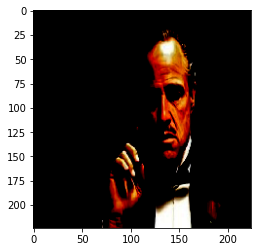

In [10]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

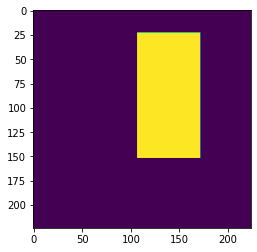

In [ ]:
pyplot.imshow(masks[n])

**Create the model**

In [11]:
# Import the libraries
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate,UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [12]:
def create_model(trainable=True):
  model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0 , weights="imagenet")

  for layer in model.layers:
    layer.trainable = trainable

  # Add all the UNET layers
  block1 = model.input
  block2 = model.get_layer("conv_pw_1_relu").output
  block3 = model.get_layer("conv_pw_3_relu").output
  block4 = model.get_layer("conv_pw_5_relu").output
  block5 = model.get_layer("conv_pw_11_relu").output
  block6 = model.get_layer("conv_pw_13_relu").output

  
  x = Concatenate()([UpSampling2D()(block6), block5])
  x = Concatenate()([UpSampling2D()(x), block4])
  x = Concatenate()([UpSampling2D()(x), block3])
  x = Concatenate()([UpSampling2D()(x), block2])
  x = Concatenate()([UpSampling2D()(x), block1])
 
  x= Conv2D(1, kernel_size=1, activation="sigmoid")(x)
  x= Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

  return Model(inputs=model.input, outputs=x)

**Create Model**

In [13]:
model = create_model()

model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________

**Dice Coefficient**

In [14]:
import tensorflow as tf
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

**Loss**

In [15]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

**Compile the Model**

In [16]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

**Define checkpoint and earlystopping**

In [ ]:
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

**Fit the model**

In [ ]:
model.fit(x= X_train, y= masks, epochs=50, batch_size=1, verbose=1, callbacks = [checkpoint, stop, reduce_lr])

Epoch 1/50
409/409 [==============================] - ETA: 0s - loss: 1.3106 - dice_coefficient: 0.4492
Epoch 00001: loss improved from inf to 1.31057, saving model to model-1.31.h5
409/409 [==============================] - 537s 1s/step - loss: 1.3106 - dice_coefficient: 0.4492 - lr: 1.0000e-04
Epoch 2/50
409/409 [==============================] - ETA: 0s - loss: 0.7977 - dice_coefficient: 0.6117
Epoch 00002: loss improved from 1.31057 to 0.79774, saving model to model-0.80.h5
409/409 [==============================] - 535s 1s/step - loss: 0.7977 - dice_coefficient: 0.6117 - lr: 1.0000e-04
Epoch 3/50
409/409 [==============================] - ETA: 0s - loss: 0.6277 - dice_coefficient: 0.6752
Epoch 00003: loss improved from 0.79774 to 0.62767, saving model to model-0.63.h5
409/409 [==============================] - 534s 1s/step - loss: 0.6277 - dice_coefficient: 0.6752 - lr: 1.0000e-04
Epoch 4/50
409/409 [==============================] - ETA: 0s - loss: 0.5876 - dice_coefficient: 0.69

In [ ]:
# load the last saved weights
model.load_weights('model-0.23.h5')

In [ ]:
# contrinue training
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

model.fit(x= X_train, y= masks, epochs=50, batch_size=1, verbose=1, callbacks = [checkpoint, stop, reduce_lr])


Epoch 1/50
409/409 [==============================] - ETA: 0s - loss: 0.2295 - dice_coefficient: 0.8769
Epoch 00001: loss improved from inf to 0.22954, saving model to model-0.23.h5
409/409 [==============================] - 497s 1s/step - loss: 0.2295 - dice_coefficient: 0.8769 - lr: 1.0000e-04
Epoch 2/50
409/409 [==============================] - ETA: 0s - loss: 0.2371 - dice_coefficient: 0.8733
Epoch 00002: loss did not improve from 0.22954
409/409 [==============================] - 486s 1s/step - loss: 0.2371 - dice_coefficient: 0.8733 - lr: 1.0000e-04
Epoch 3/50
409/409 [==============================] - ETA: 0s - loss: 0.2337 - dice_coefficient: 0.8756
Epoch 00003: loss did not improve from 0.22954
409/409 [==============================] - 480s 1s/step - loss: 0.2337 - dice_coefficient: 0.8756 - lr: 1.0000e-04
Epoch 4/50
409/409 [==============================] - ETA: 0s - loss: 0.2264 - dice_coefficient: 0.8793
Epoch 00004: loss improved from 0.22954 to 0.22636, saving model to

In [ ]:
model.fit(x= X_train, y= masks, epochs=20, batch_size=1, verbose=1, callbacks = [checkpoint, stop, reduce_lr])

Epoch 1/20
409/409 [==============================] - ETA: 0s - loss: 0.1819 - dice_coefficient: 0.9062
Epoch 00001: loss did not improve from 0.18119
409/409 [==============================] - 512s 1s/step - loss: 0.1819 - dice_coefficient: 0.9062 - lr: 1.0000e-04
Epoch 2/20
409/409 [==============================] - ETA: 0s - loss: 0.1808 - dice_coefficient: 0.9070
Epoch 00002: loss improved from 0.18119 to 0.18079, saving model to model-0.18.h5
409/409 [==============================] - 515s 1s/step - loss: 0.1808 - dice_coefficient: 0.9070 - lr: 1.0000e-04
Epoch 3/20
409/409 [==============================] - ETA: 0s - loss: 0.1788 - dice_coefficient: 0.9081
Epoch 00003: loss improved from 0.18079 to 0.17878, saving model to model-0.18.h5
409/409 [==============================] - 517s 1s/step - loss: 0.1788 - dice_coefficient: 0.9081 - lr: 1.0000e-04
Epoch 4/20
409/409 [==============================] - ETA: 0s - loss: 0.1782 - dice_coefficient: 0.9085
Epoch 00004: loss improved f

In [17]:
# load the last saved weights
model.load_weights('model-0.17.h5')

In [18]:
# contrinue training
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

model.fit(x= X_train, y= masks, epochs=50, batch_size=1, verbose=1, callbacks = [checkpoint, stop, reduce_lr])

Epoch 1/50
409/409 [==============================] - ETA: 0s - loss: 0.1713 - dice_coefficient: 0.9128
Epoch 00001: loss improved from inf to 0.17126, saving model to model-0.17.h5
409/409 [==============================] - 544s 1s/step - loss: 0.1713 - dice_coefficient: 0.9128 - lr: 1.0000e-04
Epoch 2/50
409/409 [==============================] - ETA: 0s - loss: 0.1742 - dice_coefficient: 0.9115
Epoch 00002: loss did not improve from 0.17126
409/409 [==============================] - 544s 1s/step - loss: 0.1742 - dice_coefficient: 0.9115 - lr: 1.0000e-04
Epoch 3/50
409/409 [==============================] - ETA: 0s - loss: 0.1750 - dice_coefficient: 0.9112
Epoch 00003: loss did not improve from 0.17126
409/409 [==============================] - 543s 1s/step - loss: 0.1750 - dice_coefficient: 0.9112 - lr: 1.0000e-04
Epoch 4/50
409/409 [==============================] - ETA: 0s - loss: 0.1727 - dice_coefficient: 0.9127
Epoch 00004: loss did not improve from 0.17126
409/409 [===========

#### The final model has a dice coefficient of 0.92 and loss of 0.1606. Let's predict the mask for a sample image using the model trained.

***Get the predicted mask for a sample image***

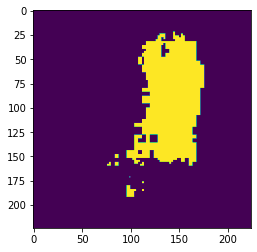

In [19]:
n = 10
sample_image = X_train[n]

#model.load_weights('model-0.16.h5')
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([sample_image]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

pyplot.imshow(pred_mask)


**Impose the mask on the image**

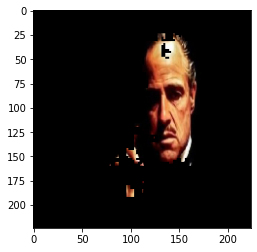

In [20]:
img = data[n][0]

image = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
img_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([img_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

pyplot.imshow(out_image)

##### The mask is imposed on the original image and output is shown above